## Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch.utils.data as data
import pandas as pd
import numpy as np
import glob
from PIL import Image
import cv2

class AGE(data.Dataset):
    def __init__(self, df_path, phase ,data_root = '', transform = None):
        self.df = pd.read_csv(df_path,sep=' ',header=None)
        self.df.columns = ['Image','Age']
        self.transform = transform
        self.root= data_root
        self.phase = phase


        print(' load successfully {} samples:'.format({len(self.df)}))

    def __len__(self):
        return len(self.df)
    def age2underage(self, age):
        if age is None:
            raise ValueError('age cannot be None')
        if age < 0:
            raise ValueError('age should be positive')
        if age <= 9:
            return 0  # u10
        elif age <= 19:
            return 1
        elif age <= 29:
            return 2
        elif age <= 39:
            return 3
        elif age <= 49:
            return 4
        elif age <= 59:
            return 5
        elif age <= 69:
            return 6
        elif age <= 79:
            return 7
        elif age > 79:
            return 8

    def __getitem__(self, idx):
        img_name,age = self.df.iloc[idx]
        img_path = self.root +'/'+ "{}/images/{}/{}".format(self.phase,age,img_name)
        image_square = cv2.imread(img_path)
        image_square = cv2.cvtColor(image_square,cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image_square)
        uage = np.ones_like(age)*self.age2underage(age)
        if uage==None:
            print(idx)
        #print("k---",age,"---l")
        if self.transform is not None:
            image = self.transform(image)
        return image, uage

**Sample of dataset**

 load successfully {144325} samples:
[69829, 58383, 78630, 19408, 75625, 90791]


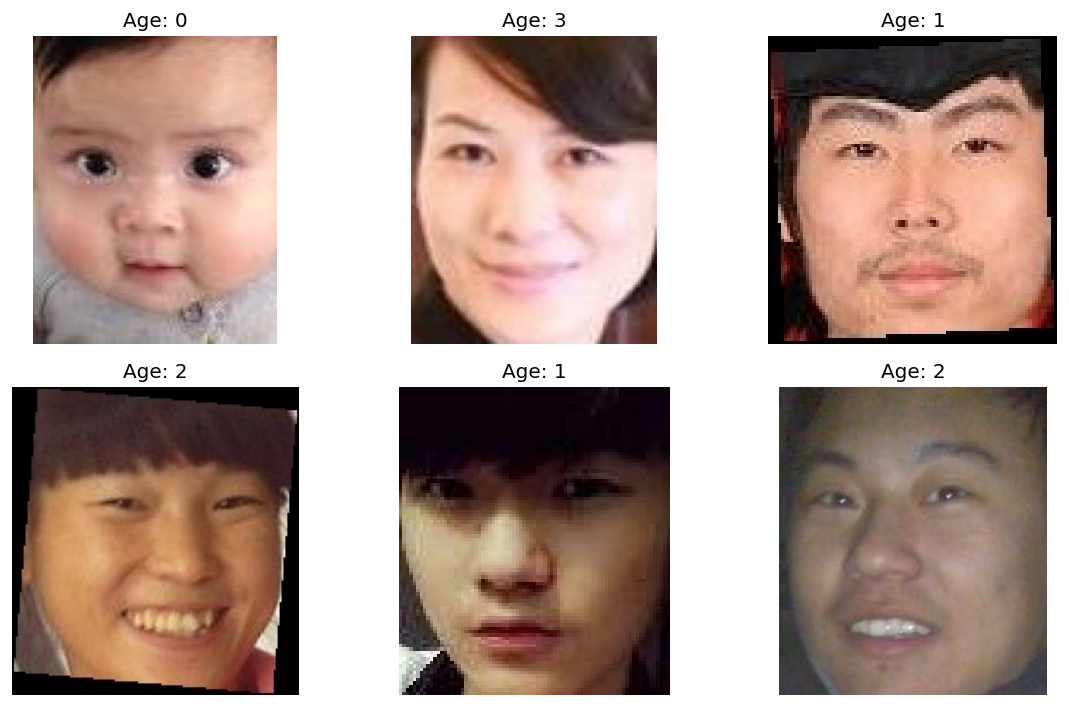

In [ ]:
### train data
import random
import matplotlib.pyplot as plt
train = AGE(df_path = '/content/iot_lab/age_train.txt',phase = 'train',data_root = 'iot_lab',transform = None)
random_idx = random.sample(range(0, len(train)), 6)
print(random_idx)
plt.figure(figsize=(10, 6),dpi=120)

for i,idx in enumerate(random_idx):
    image, label = train[idx]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Age: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
del train

 load successfully {10744} samples:
[43, 6592, 7304, 3734, 5456, 7121]


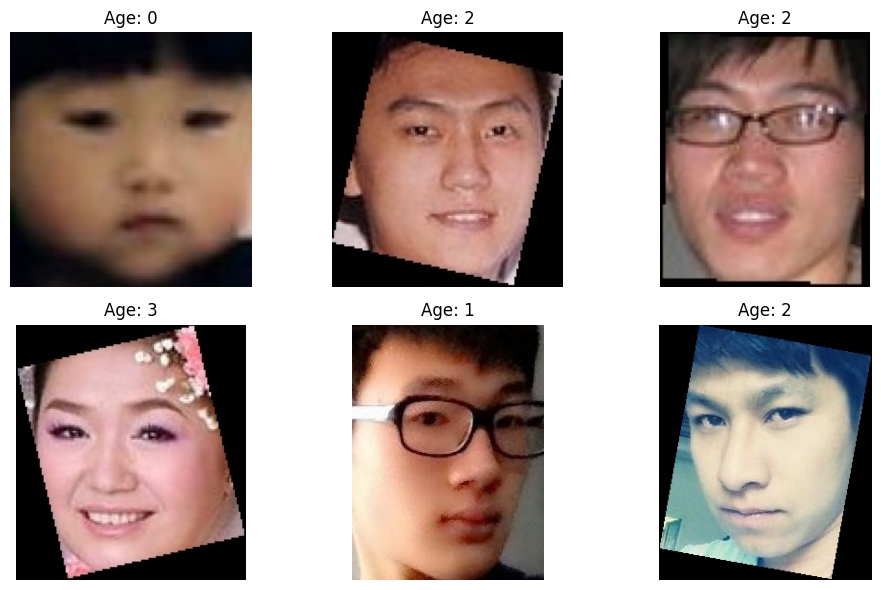

In [ ]:
import random
import matplotlib.pyplot as plt
val = AGE(df_path = 'iot_lab/age_val.txt',phase = 'valid',data_root = 'iot_lab',transform = None)
random_idx = random.sample(range(0, len(val)), 6)
print(random_idx)
plt.figure(figsize=(10, 6))

for i,idx in enumerate(random_idx):
    image, label = val[idx]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Age: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
del val

## Utils function

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
def accuracy(pred, labels):
    acc = (torch.argmax(pred.to(labels.device), 1) == labels).float().mean()
    return acc

In [ ]:
class MultiClassFocalLoss(nn.Module):
    """
    Focal Loss cho multi-class classification
    Hỗ trợ các trường hợp: one-hot, index labels
    """
    def __init__(self,
                 alpha: torch.Tensor = None,
                 gamma: float = 2.0,
                 reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Tính toán Focal Loss cho multi-class

        Args:
        - inputs: Logits (before softmax)
        - targets: Nhãn lớp

        Returns:
        Tensor loss
        """
        # Chuyển đổi targets sang one-hot nếu cần
        inputs = inputs.to(targets.device)
        if targets.ndim == 1:
            targets = targets.long()
            targets = F.one_hot(targets, num_classes=inputs.size(-1)).float()

        # Softmax cross entropy
        log_prob = F.log_softmax(inputs, dim=-1).to(targets.device)
        prob = torch.exp(log_prob)

        # Tính focal loss
        focal_loss = -(1 - prob) ** self.gamma * log_prob * targets

        # Xử lý alpha weights
        if self.alpha is not None:
            alpha_factor = torch.tensor(self.alpha, device=targets.device)
            focal_loss = alpha_factor * focal_loss

        # Áp dụng reduction
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

class FocalLossFactory:
    """
    Nhà máy tạo Focal Loss với nhiều cấu hình
    """
    @staticmethod
    def create(
        loss_type: str = 'binary',
        alpha: float = 0.25,
        gamma: float = 2.0,
        num_classes: int = None
    ) -> nn.Module:
        """
        Tạo Focal Loss theo yêu cầu

        Args:
        - loss_type: Loại loss ('binary', 'multiclass')
        - alpha: Trọng số alpha
        - gamma: Độ khó focal
        - num_classes: Số lượng lớp (cho multiclass)

        Returns:
        Đối tượng Focal Loss
        """
        if loss_type == 'binary':
            return Raise("Not support yet")
        elif loss_type == 'multiclass':
            if num_classes is None:
                raise ValueError("Cần chỉ định num_classes cho multiclass")

            # Tạo alpha mặc định nếu không được cung cấp
            alpha = torch.ones(num_classes) * alpha
            return MultiClassFocalLoss(alpha=alpha, gamma=gamma)
        else:
            raise ValueError(f"Không hỗ trợ loss type: {loss_type}")

## training

In [3]:
import torch
import torchvision
from torch import nn
import torch
import timm
from timm.layers import SelectAdaptivePool2d

class Mobilenetv2(nn.Module):
    def __init__(self,mode="train",max_age_group=9):
        super(Mobilenetv2,self).__init__()
        self.mode = mode
        self.name = 'timm/mobilenetv2_140.ra_in1k'
        self.model = timm.create_model(self.name, pretrained=True)
        self.model.classifier = nn.Identity()
        self.age_head = nn.Sequential(
            nn.Linear(1792,max_age_group),
            nn.ReLU()
        )
    def forward(self,x):
        x = self.model(x)
        age = self.age_head(x)

        if self.mode == 'train':
            return age
        if self.mode == 'predict':
            return age.softmax(-1).argmax(-1)
        sq = lambda x:x.squeeze()
        age_p,age = age.softmax(1).max(1)
        return sq(age),sq(age_p)

In [ ]:
import os
import random
from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

class AGETrainer:
    def __init__(self, config: Dict):
        """
        Khởi tạo trainer với cấu hình chi tiết

        Args:
            config (Dict): Từ điển cấu hình cho quá trình huấn luyện
        """
        # Cài đặt seed
        self.seed = config.get('seed', 34)
        self._set_seed()

        # Cấu hình môi trường
        self.debug = config.get('debug', False)
        self.run = self._setup_environment()

        # Cấu hình mô hình
        self.device = torch.device(config.get('device', 'cuda' if torch.cuda.is_available() else 'cpu'))
        self.batch_size = config.get('batch_size', 768)
        self.epochs = config.get('epochs', 100)
        self.width = config.get('width', 112)

        # Khởi tạo transforms
        self.train_transform, self.val_transform = self._get_transforms()

        # Chuẩn bị datasets
        self.train_dataset, self.val_dataset = self._prepare_datasets()

        # Khởi tạo dataloader
        self.train_loader = self._create_dataloader(self.train_dataset, shuffle=True)
        self.val_loader = self._create_dataloader(self.val_dataset, shuffle=False)

        # Khởi tạo mô hình và optimizer
        self.model, self.optimizer, self.scheduler, self.loss_functions = self._setup_model_and_optimizer()

        # Logging
        self.log_file = f'output/run_{self.run}/log.txt'

    def _set_seed(self):
        """Thiết lập seed để đảm bảo tính tái lập"""
        random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def _setup_environment(self) -> int:
        """
        Khởi tạo môi trường và thư mục

        Returns:
            int: Số thứ tự của lần chạy
        """
        os.makedirs('output', exist_ok=True)
        run = len(os.listdir('output')) + 1
        os.mkdir(f'output/run_{run}')
        return run

    def _get_transforms(self) -> Tuple[T.Compose, T.Compose]:
        """
        Tạo transform cho quá trình huấn luyện và validation

        Returns:
            Tuple của train và validation transforms
        """
        train_transform = T.Compose([
            T.Resize((self.width, self.width)),
            T.ToTensor(),
            T.RandomHorizontalFlip(),
            T.RandomAffine(
                degrees=14,
                translate=(0.2, 0.15),
            ),
            T.ColorJitter(brightness=0.25, contrast=0.2, saturation=0.2),
            T.RandomPerspective(distortion_scale=0.1, p=0.5),
            T.RandomErasing(p=0.5, scale=(0.02, 0.02), ratio=(0.1, 0.5)),
            T.RandomGrayscale(0.1),
        ])

        val_transform = T.Compose([
            T.Resize((self.width, self.width)),
            T.ToTensor()
        ])

        return train_transform, val_transform

    def _prepare_datasets(self) -> Tuple[ConcatDataset, ConcatDataset]:
        """
        Chuẩn bị datasets cho huấn luyện và validation

        Returns:
            Tuple của train và validation datasets
        """

        # Datasets

        train = AGE(df_path = 'iot_lab/age_train.txt',phase = 'train',data_root = 'iot_lab',transform = self.train_transform)
        val = AGE(df_path = 'iot_lab/age_val.txt',phase = 'valid',data_root = 'iot_lab',transform = self.val_transform)

        # Debug mode
        if self.debug:
            train = Subset(train, range(10000))
            val = Subset(val, range(2000))

        return train, val

    def _create_dataloader(self, dataset, shuffle=True) -> DataLoader:
        """
        Tạo DataLoader từ dataset

        Args:
            dataset: Dataset đầu vào
            shuffle: Có trộn dữ liệu không

        Returns:
            DataLoader
        """
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=16
        )

    def _setup_model_and_optimizer(self) -> Tuple[nn.Module, optim.Optimizer, optim.lr_scheduler._LRScheduler, Dict[str, nn.Module]]:
        """
        Thiết lập mô hình, optimizer và loss functions

        Returns:
            Tuple của (model, optimizer, scheduler, loss_functions)
        """

        model = Mobilenetv2().to(self.device)

        optim_params = {
            'lr': 0.005,
            'betas': (0.9, 0.999),
            'weight_decay': 1e-4
        }

        optimizer = optim.Adam(model.parameters(), **optim_params)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.12)

        # Định nghĩa loss functions
        loss_functions = {
            'age': FocalLossFactory.create(
                    loss_type='multiclass',
                    num_classes=9,
                    alpha=0.25,
                    gamma=2.0
                ),
        }

        return model, optimizer, scheduler, loss_functions

    def _training_val_step(self, img: torch.Tensor, labels: List[torch.Tensor], val: bool = False) -> Tuple[Tuple[float, float, float], float]:
        """
        Thực hiện một bước huấn luyện hoặc validation

        Args:
            img: Tensor ảnh đầu vào
            labels: Danh sách nhãn
            val: Chế độ validation

        Returns:
            Tuple của (accuracies, total_loss)
        """

        with torch.set_grad_enabled(not val):
            self.model.train(not val)

            pred_age = self.model(img)
            age = labels

            age = age.float()

            # Tính toán loss với trọng số
            total_loss = self.loss_functions['age'](pred_age, age)

            if not val:
                self.optimizer.zero_grad(set_to_none=True)
                total_loss.backward()
                self.optimizer.step()

            # Tính accuracy
            accuracies = accuracy(pred_age, age).item()


            return accuracies, total_loss.item()

    def train(self):
        """
        Thực hiện quá trình huấn luyện hoàn chỉnh
        """
        best_model_score = 0

        for epoch in range(self.epochs):
            torch.cuda.empty_cache()

            # Reset tracking metrics
            train_metrics = {'loss': 0, 'age_acc': 0}
            val_metrics = {'loss': 0, 'age_acc': 0}

            # Huấn luyện
            self.model.train()
            for i, (img, labels) in enumerate(self.train_loader, 1):
                print(f'Training epoch: {epoch+1}/{self.epochs}, step: {i}/{len(self.train_loader)}', end='\r')
                labels = [l.to(self.device) for l in labels]
                age_acc, batch_loss = self._training_val_step(
                    img.to(self.device), torch.tensor(labels)
                )

                train_metrics['loss'] += batch_loss
                train_metrics['age_acc'] += age_acc

            # Đánh giá
            self.model.eval()
            with torch.no_grad():
                for img, labels in self.val_loader:
                    labels = [l.to(self.device) for l in labels]
                    age_acc, batch_loss = self._training_val_step(
                        img.to(self.device), torch.tensor(labels), val=True
                    )

                    val_metrics['loss'] += batch_loss
                    val_metrics['age_acc'] += age_acc

            # Tính trung bình metrics
            for key in train_metrics:
                train_metrics[key] /= len(self.train_loader)
            for key in val_metrics:
                val_metrics[key] /= len(self.val_loader)

            # Tính điểm mô hình
            score = 0.5 * (1/val_metrics['age_acc']) + 0.01 * val_metrics['loss']

            # Log kết quả
            log_message = (
                f"Epoch {epoch}: "
                f"Train Loss={train_metrics['loss']:.4f}, "
                f"Val Loss={val_metrics['loss']:.4f}, "
                f"Val Accuracy={val_metrics['age_acc']:.4f}, "
                f"Score={score:.4f}"
            )
            print(log_message)

            with open(self.log_file, 'a') as f:
                f.write(log_message + '\n')

            # Lưu mô hình tốt nhất
            if score > best_model_score:
                best_model_score = score
                torch.save({
                    'model': self.model.name,
                    'weights': self.model.state_dict(),
                    'score': score
                }, f'output/run_{self.run}/best_model.pt')

            # Lưu mô hình định kỳ
            if epoch % 10 == 0:
                torch.save({
                    'model': self.model.name,
                    'weights': self.model.state_dict(),
                    'score': score
                }, f'output/run_{self.run}/model_epoch_{epoch}.pt')

            self.scheduler.step()


config = {
        'seed': 30,
        'debug': False,
        'device': 'cuda',
        'batch_size': 128,
        'epochs': 100,
        'width': 224
    }

trainer = AGETrainer(config)
trainer.train()


## Predict

In [1]:
import torch
import torchvision
from torch import nn
import torch
import timm
from timm.layers import SelectAdaptivePool2d

class Mobilenetv2(nn.Module):
    def __init__(self,mode="train",max_age_group=9):
        super(Mobilenetv2,self).__init__()
        self.mode = mode
        self.name = 'timm/mobilenetv2_140.ra_in1k'
        self.model = timm.create_model(self.name, pretrained=True)
        self.model.classifier = nn.Identity()
        self.age_head = nn.Sequential(
            nn.Linear(1792,max_age_group),
            nn.ReLU()
        )
    def forward(self,x):
        x = self.model(x)
        age = self.age_head(x)

        if self.mode == 'train':
            return age
        if self.mode == 'predict':
            return age.softmax(-1).argmax(-1)
        sq = lambda x:x.squeeze()
        age_p,age = age.softmax(1).max(1)
        return sq(age),sq(age_p)

In [6]:
model =  Mobilenetv2(mode='predict')
checkpoint = torch.load('/content/drive/MyDrive/CH/kpdl/best_model.pt',weights_only=True, map_location='cpu')
model.load_state_dict(checkpoint['weights'])
model.eval()
print("load model done!")

load model done!


In [7]:
from PIL import Image
from torchvision import transforms as T

val_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])
label2text = {0:"U10",
              1:"U20",
              2:"U30",
              3:"U40",
              4:"U50",
              5:"U60",
              6:"U70",
              7:"U80",
              8:"O80"}

In [ ]:
!pip install gradio

In [13]:
import gradio as gr
import torch

def predict_age(image):
    img = val_transform(image).unsqueeze(0)  # Tiền xử lý ảnh
    with torch.no_grad():
        age = model(img)[0].argmax().item()  # Lấy nhãn có xác suất cao nhất
    return f"Độ tuổi khoảng: {label2text[age]}"

demo = gr.Interface(
    fn=predict_age,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Dự đoán độ tuổi từ ảnh",
    description="Tải lên ảnh chân dung và xem dự đoán độ tuổi thuộc nhóm U nào (U10, U20, U30,...)."
)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://045680bde2d015d7b9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
